In [2]:
import numpy as np
from scipy.stats.stats import pearsonr
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.time import Time

from os.path import exists 
from GPbaseband1 import *

#Using latex rendering:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

text_name = 'good_pulses.txt'
with open(text_name, 'r') as f:
    text = f.read()
    text_lines = text.split('\n')

/opt/python/2.7.10/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [17]:
# %pylab inline
def get_SN(outputsumfreq):
    noise_std = np.std(outputsumfreq[:5]) 
    noise_mean = np.mean(outputsumfreq[:5])
    sigs_noise = (outputsumfreq-noise_mean)/noise_std
    return sigs_noise

def process_freq_spec(gp1,nchan,index=None,draw=0):
    '''function takes a continuous frequency spectrum and cuts it into 8 bands, divide by the giant pulse mean, and normalize it by itself gp1=freq_spec[i]. function also plots the frequency spectrum'''
    gp1_8=np.array([gp1[int(40./512*nchan):int(465./512*nchan)]])
    for j in range(7):gp1_8=np.append(gp1_8,np.array([gp1[(j+1)*(nchan+1)+int(40./512*nchan):(j+1)*(nchan+1)+int(465./512*nchan)]]),0)
#     gp1_8/=gpab #Dividing by giant pulse average
#     for i in range(8):gp1_8[i]=gp1_8[i]/gp1_8[i].mean()-1.
    if draw:
        f,axarr=plt.subplots(8,1,figsize=(10,15))

        for i in range(8):axarr[i].plot(gp1_8[i])
        axarr[0].set_title('Frequency spectrum of giant pulse at {}'.format(time_values[index]))
    return gp1_8

def load_gp(time_string,telescope,nchan,draw = 0):
    '''Takes in a time string, a string indicating whcih telescope to use, and an interger of nchan'''
    gp1 = np.load('/home/ramain/GPs/GPp1/p{}.npy'.format(time_string))
    gp1t = np.fft.irfft(gp1,axis=1)
    gp1s = gp1t.reshape(-1,2*nchan,16)
    gp1s = np.fft.rfft(gp1s,axis=1)
    dchan = gp1s
    dR = np.concatenate((dchan[:,::-1,8], dchan[...,0], dchan[:,::-1,10], dchan[...,2], dchan[:,::-1,12], dchan[...,4], dchan[:,::-1,14], dchan[...,6]), axis=1)
    dL = np.concatenate((dchan[:,::-1,9], dchan[...,1], dchan[:,::-1,11], dchan[...,3], dchan[:,::-1,13], dchan[...,5], dchan[:,::-1,15], dchan[...,7]), axis=1)
    output = (abs(dR)**2 + abs(dL)**2).T


    outputsumfreq = output.sum(0) #dedispersed
    #computes signal to noise after summing all the frequencies
    sigs_noise = get_SN(outputsumfreq)
    
    S_N = max(sigs_noise)
    peak_time = np.argmax(sigs_noise)

#     xlim(100,175)
    
    if nchan ==512 or nchan ==128:
        background_std1 = output[40./512*nchan:465./512*nchan,:peak_time-1].std()
#         print 'std1 =',background_std1
        background_std2 = output[:,peak_time+2:].std()
        output_pulse = output[:,peak_time]
#         print 'std2 =',background_std2
    
#     if nchan ==128:
#         pass
    
    if nchan ==32:
        background_1= output[40./512*nchan:465./512*nchan,peak_time-12:peak_time-6].mean(1)
        background_std1 = background_1.std()
#         print 'std1 =',background_std1
        background_std2 = output[:,peak_time+10:].std()
        output_pulse = output[:,peak_time-1:peak_time+5].mean(1)
#         print 'std2 =',background_std2
    
    background_freq = output[:,peak_time-3]
    freq_spec = output_pulse-background_freq
#     freq_spec = output_pulse
#     figure()
#     plot(output_pulse)
#     plot(background_freq)
    
    if draw:
        figure(figsize = (10,3))
        plot(outputsumfreq)
        figure()
        plot(sigs_noise)
    return freq_spec,background_std1

nchan = 128
tele1 = 'jb'
tele2 = 'ef'
time_string1 = '2015-10-19T00:17:47.415' # S/N = 89!, main pulse 
time_string2 = '2015-10-19T02:35:26.143' # S/N = 43, main pulse 
time_string3 = '2015-10-19T02:06:52.280' #S/N = 7.9, inter pulse
time_string4 = '2015-10-19T02:06:58.031' #S/N = 9.6, main pulse
time_string5 = '2015-10-19T00:55:15.557' #S/N = 8.33, main pulse
time_string6 = '2015-10-19T00:55:49.673' #S/N = 8.55, main pulse
time_string7 = '2015-10-19T01:29:52.509' #S/N = 8.44, main pulse
time_string8 = '2015-10-19T01:55:06.340' #S/N = 8.66, main pulse
time_string9 = '2015-10-19T02:13:46.551' #S/N = 9.56, main pulse
time_string10 = '2015-10-19T02:36:11.418'#S/N = 8.41, main pulse

S_N3= 7.9
S_N4 = 9.6
time_string = time_string10
fs1,bgstd1 = load_gp(time_string,tele1,nchan)
fs2,bgstd2 = load_gp(time_string,tele2,nchan)

/opt/python/2.7.10/lib/python2.7/site-packages/ipykernel/__main__.py:43: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [7]:
def get_cc((fs1,bgstd1),(fs2,bgstd2)):
    mean1 = np.mean(fs1)
    mean2 = np.mean(fs2)
    numerator = np.mean((fs1-mean1)*(fs2-mean2))
    denominator = np.sqrt(((np.std(fs1))**2-bgstd1**2)*((np.std(fs2))**2-bgstd2**2))
#     denominator = np.std(fs1)*np.std(fs2)
    return numerator/denominator
    
def get_ccs((fs1,bgstd1),(fs2,bgstd2)):
    coefficients= []
    for i in range(8):
        X = fs1[i]
        Y = fs2[i]
#         Xbg = bgstd1[i]
#         Ybg = fs2bg[i]
        coefficient = get_cc((X,bgstd1),(Y,bgstd2))
        coefficients.append(coefficient) 
    return np.mean(coefficients),coefficients

# cc,ccs=get_ccs((fgp1,fgp1bg),(fgp2,fgp2bg))

In [18]:
nchan = 32

ctvalues = np.zeros(shape = (0,2))
for i,time_string1 in enumerate(text_lines[:-1]):
    for j,time_string2 in enumerate(text_lines[i:-1]):
        t_gp1 = Time(time_string1)
        t_gp2 = Time(time_string2)
        dt = t_gp2-t_gp1
        if 1e-5<abs(dt.sec)<100:
            fs1,bgstd1 = load_gp(time_string1,'ef',nchan)
            fs2,bgstd2 = load_gp(time_string2,'ef',nchan)
            fgp1 = process_freq_spec(fs1,nchan,i-1,draw = 0)
            fgp2 = process_freq_spec(fs2,nchan,i+j-1)
            cc,ccs=get_ccs((fgp1,bgstd1),(fgp2,bgstd2))
            ctvalues=np.append(ctvalues,np.array([[ccs[0],abs(dt.sec)]]),axis = 0)
np.save('./figures/correlation_coeff/{}_{}ctvalues_jun21.npy'.format(text_name,nchan),ctvalues)


/opt/python/2.7.10/lib/python2.7/site-packages/ipykernel/__main__.py:53: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Populating the interactive namespace from numpy and matplotlib


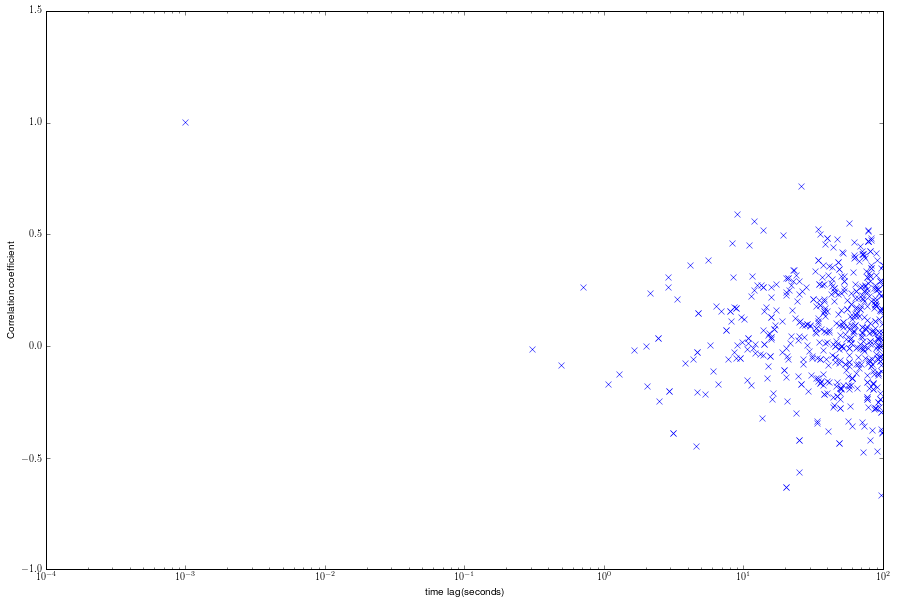

In [20]:
%pylab inline
figure(figsize = (15,10))
semilogx(ctvalues[:,1],ctvalues[:,0],'x')
xlabel('time lag(seconds)')
# ylim(-0.2,0.5)
ylabel('Correlation coefficient')


In [16]:
text_lines


['2015-10-18T23:11:29.352',
 '2015-10-18T23:14:03.584',
 '2015-10-18T23:14:08.202',
 '2015-10-18T23:14:08.202',
 '2015-10-18T23:16:40.209',
 '2015-10-18T23:17:40.991',
 '2015-10-18T23:18:21.412',
 '2015-10-18T23:19:34.431',
 '2015-10-18T23:21:15.365',
 '2015-10-18T23:21:34.479',
 '2015-10-18T23:21:42.604',
 '2015-10-18T23:21:58.347',
 '2015-10-18T23:24:57.627',
 '2015-10-18T23:25:08.313',
 '2015-10-18T23:27:06.743',
 '2015-10-18T23:27:23.667',
 '2015-10-18T23:28:34.192',
 '2015-10-18T23:29:22.278',
 '2015-10-18T23:29:31.212',
 '2015-10-18T23:30:59.961',
 '2015-10-18T23:31:38.461',
 '2015-10-18T23:31:40.955',
 '2015-10-18T23:33:00.313',
 '2015-10-18T23:34:42.662',
 '2015-10-18T23:39:43.405',
 '2015-10-18T23:40:57.908',
 '2015-10-18T23:41:53.277',
 '2015-10-18T23:43:53.008',
 '2015-10-18T23:45:19.681',
 '2015-10-18T23:45:26.558',
 '2015-10-18T23:46:10.046',
 '2015-10-18T23:47:12.817',
 '2015-10-18T23:47:12.817',
 '2015-10-18T23:47:20.315',
 '2015-10-18T23:47:20.807',
 '2015-10-18T23:47:2